# 2019 Design Census: Let's Build a Data Dictionary
<figure style="float:right">
  <img src="img/design_census/black-pencils.jpg" alt="Black pencils" style="width:400px">
    <figcaption><em>Photo by Kaboompics .com from Pexels</em></figcaption>
</figure> ** 21 November 2019**

## Background
I knew that I wanted to focus on building a data dictionary this week. When I saw the Design Census dataset, I thought, "hey, data dictionaries are about design, right?" So I figured I would make the dataset work for the idea. As it turned out, this dataset desperately needed a dictionary. While the column names are whimsical, they are not very descriptive. In fact some ("I have" vs "I've had"), are just plain confusing until you look at the data. So let's look at the data and start building the dictionary.

## Sources
https://designcensus.org/<br />
https://gist.github.com/erichurst/7882666 (ZIP codes with longitude and latitude)

## Possible Next Steps
Honestly, [DesignCensus.org](https://designcensus.org/) does a pretty good job at breaking down this dataset. However, there are lots of directions to take it if you really want to explore the data. For example, you could build upon the map that I made by breaking different variables into geographic areas. Or simply try to recreate some the the breakdowns on [DesignCensus.org](https://designcensus.org/).

In [1]:
from collections import Counter
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pywaffle import Waffle
from matplotlib import cm

import folium
from folium.plugins import MarkerCluster

#plt.style.use("seaborn-colorblind")

In [2]:
%load_ext watermark
%watermark -d -v -iv

numpy   1.16.5
pandas  0.24.2
seaborn 0.9.0
folium  0.10.0
2019-11-19 

CPython 3.7.3
IPython 7.8.0


In [3]:
# load the data
census_data = pd.read_csv("data/DesignCensus2019.csv")

In [4]:
# define zip code as string to avoid dropping 0XXXX codes
census_data["My ZIP code is:"] = census_data["My ZIP code is:"].astype(str)

In [5]:
# load zip code data
zipcodes = pd.read_csv("data/zipcodes.txt", dtype={"ZIP":str})

In [6]:
# merge design census and zip code datasets
census_data = pd.merge(census_data, zipcodes, left_on="My ZIP code is:", right_on="ZIP")

In [7]:
# take a look
census_data.head()

,I've worked in design for:,I work in:,Industries I work with:,My skills include:,I am currently learning:,I am currently a/an:,I work in:.1,I work in:.2,I work in:.3,I'm not currently working because:,...,LGBTQIA+ status:,I am:.2,I feel the most critical issues/challenges currently facing design are:,I feel the most critical issues/challenges currently facing design are:.1,I think the emerging/future technologies that will have the biggest impact on design are:,I think the most critical design skills for the future will be:,My main priorities are:,ZIP,LAT,LNG
0,5 - 9 years,Communication / Graphic design|Environmental d...,Consulting|Consumer goods|Retail,Art direction|Drawing / Painting|Project manag...,Art direction|Data visualization|Drawing / Pai...,Freelance,Branding|Industrial design|Other,NaN,NaN,NaN,...,No,White / Caucasian,Design's role in consumerism|Environmental imp...,"Field over saturation, environmental impact, p...",Energy technology|Image recognition|Networked ...,Communication / Listening|Cross-cultural skill...,Work / Career|Family / Friends / Pets|Travel,10010,40.739065,-73.982255
1,10 - 14 years,Communication / Graphic design|Illustration|Pa...,Consumer goods|Marketing|Publishing|Social media,Art direction|Drawing / Painting|Public speaking,Project management|Writing (published articles),Full-time employee (in-house),NaN,NaN,NaN,NaN,...,Yes,White / Caucasian,Automation in the workplace|Design/designers n...,NaN,3D printing|AR / VR|Automation|Image recogniti...,Cross-cultural skills|Empathy|Storytelling,Work / Career|Side hustle / Passion project|Tr...,10010,40.739065,-73.982255
2,1 - 4 years,Communication / Graphic design|UI design|UX de...,Arts / Entertainment|Digital products + servic...,Drawing / Painting|Photography|Public speaking...,Copywriting|Research|UI design|UX design,Full-time employee (agency/consultancy),Branding|Digital product design,NaN,NaN,NaN,...,No,Asian,Designing for disabilities|Design's role in co...,NaN,AI / Machine learning|AR / VR|Biological / Gen...,Adaptability (to tech / social change)|Communi...,Work / Career|Hobbies|Travel,10010,40.739065,-73.982255
3,15 - 20 years,Experience design|Interaction design|UI design...,"Digital products + services (web design, app d...",Coding|Film / Video|UI design|UX design,Coding|Leadership|Mentoring|Research,Full-time employee (agency/consultancy),Media,NaN,NaN,NaN,...,No,Asian,Diversity in design + tech|Multi-generational ...,"Diversity is a big problem, as much as it in o...",AI / Machine learning|Automation|Conversationa...,Cross-cultural skills|Experimentation / Play|S...,Work / Career,10010,40.739065,-73.982255
4,1 - 4 years,Education|Research|UI design|UX design,Education,Facilitation|Leadership|Research|UI design|UX ...,Facilitation|UI design|UX design,Full-time employee (in-house),NaN,Education|For-Profit,NaN,NaN,...,No,Asian,Designing for disabilities|Design/designers no...,NaN,AI / Machine learning|AR / VR|Automation|Biolo...,Cross-functional / Multi-disciplinary skills|D...,Work / Career|Family / Friends / Pets|Travel,10010,40.739065,-73.982255


We can see that we have a lot of categorical data. Some variables also allow for multiple responses, which are divided by a pipe `|`, so we will need to figure out how to deal with that. We can also see that we have some missing values, but I'm not going to worry too much about that at this time, but we can get a general sense of where data is missing by looking at the info.

In [8]:
census_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8686 entries, 0 to 8685
Data columns (total 43 columns):
I've worked in design for:                                                                   8686 non-null object
I work in:                                                                                   8686 non-null object
Industries I work with:                                                                      8686 non-null object
My skills include:                                                                           8686 non-null object
I am currently learning:                                                                     8686 non-null object
I am currently a/an:                                                                         8686 non-null object
I work in:.1                                                                                 3421 non-null object
I work in:.2                                                                                 36

In [9]:
def split_and_plot(col, delim="|", figsize=(12, 9), title="Plot Title"):
    """
    A function to split responses with multiple answers, iteratively count the number
    of times a specific response is given, and then create a bar plot.
    
    Parameter
    =============================================================================
    col: (string), the name of the column to split and plot
    delim: (string), the delimiter demarking different answers in a single response
    figsize: (tuple of float), defines the size of matplotlib figure
    title: (string), desired title of the plot
    """
    # create list of answers from responses
    split_list = list(
        itertools.chain(*census_data[col].dropna().str.split("|").tolist())
    )
    
    # create dataframe from response counts dictionary
    df = pd.DataFrame.from_dict(Counter(split_list), orient="index").reset_index()
    df.columns = ["NewCol", "Count"]
    df = df.sort_values(by="Count", ascending=False)
    
    # plot those bars
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(y="NewCol", x="Count", data=df, color="lightseagreen", ax=ax)
    sns.despine(ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(title, fontsize=16)

In [36]:
def plot_categories(y, title, figsize=(9,5), color="lightseagreen", order=None):
    '''
    A cheap wrapper function to create a bar plot of categorical features. 
    '''
    fig, ax = plt.subplots(figsize=figsize)
    sns.countplot(
        y=y,
        data=census_data,
        ax=ax,
        color=color,
        order=order
    )
    sns.despine(ax=ax)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(title, fontsize=16)
    
    return ax

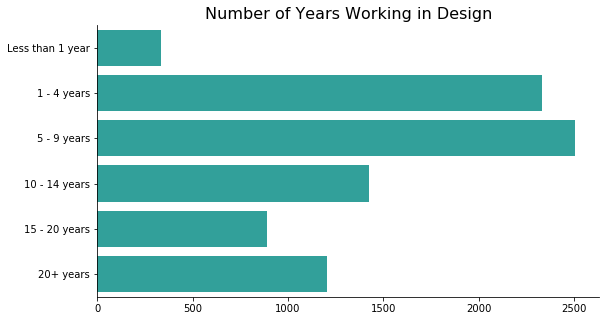

In [11]:
plot_categories(
    y="I've worked in design for:",
    order=[
        "Less than 1 year",
        "1 - 4 years",
        "5 - 9 years",
        "10 - 14 years",
        "15 - 20 years",
        "20+ years",
    ],
    title="Number of Years Working in Design",
)

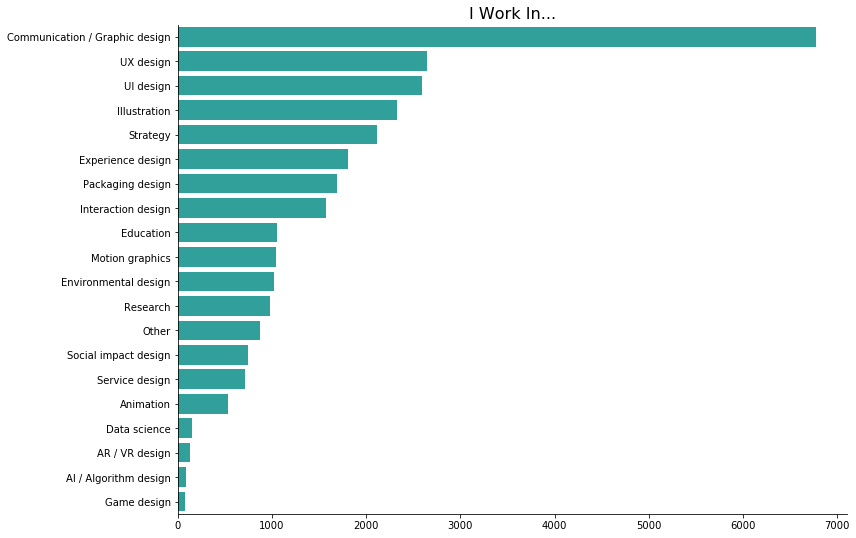

In [19]:
split_and_plot(col="I work in:", title="I Work In...")
plt.savefig("img/design_census/i_work_in.png", bbox_inches="tight")

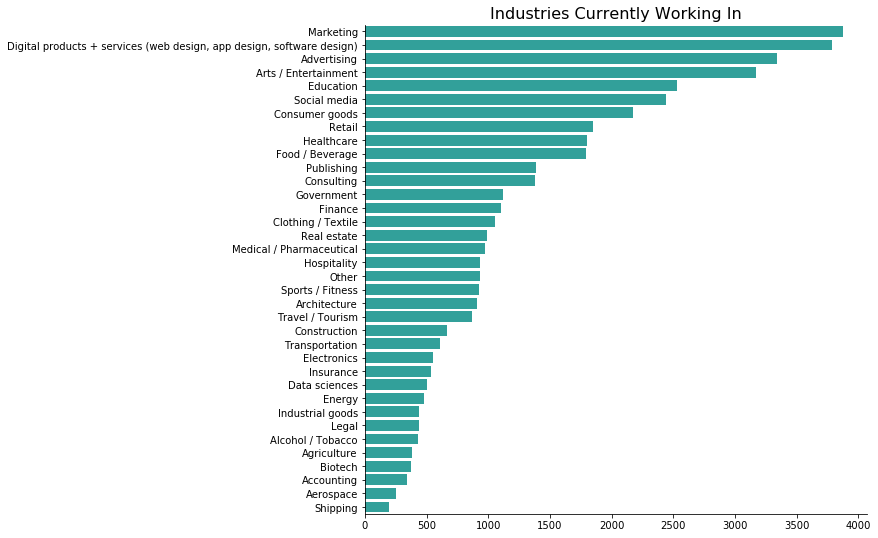

In [13]:
split_and_plot(
    col="Industries I work with:",
    title="Industries Currently Working In",
    figsize=(9, 9),
)

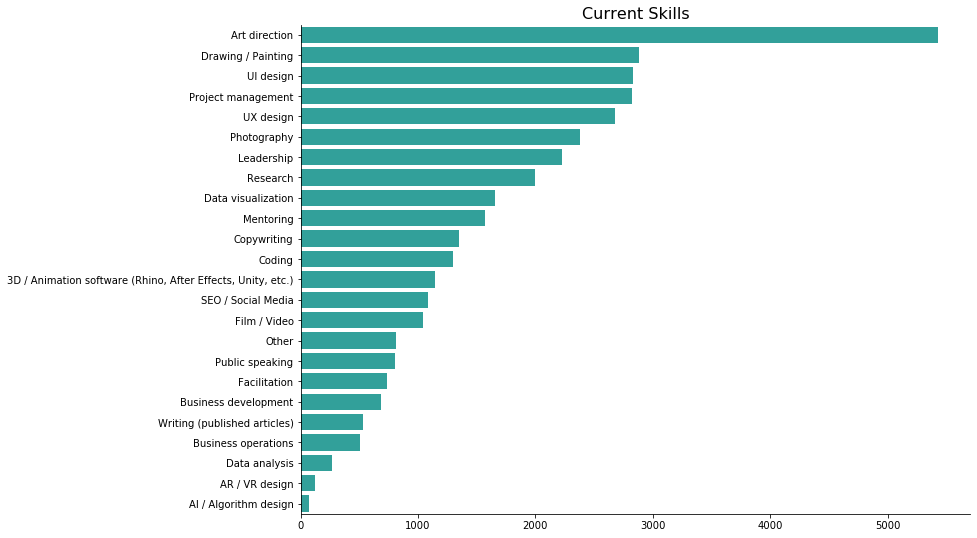

In [14]:
split_and_plot(col="My skills include:", title="Current Skills")

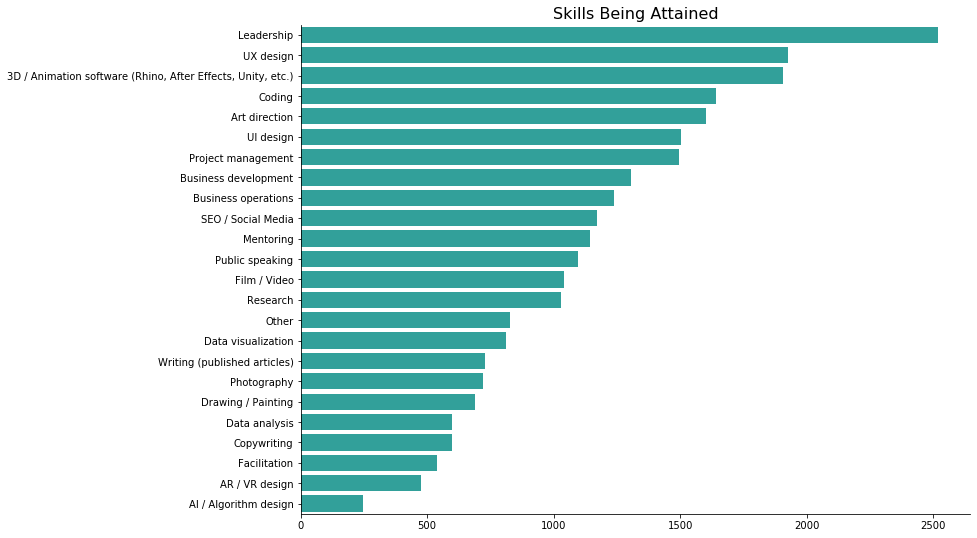

In [15]:
split_and_plot(col="I am currently learning:", title="Skills Being Attained")

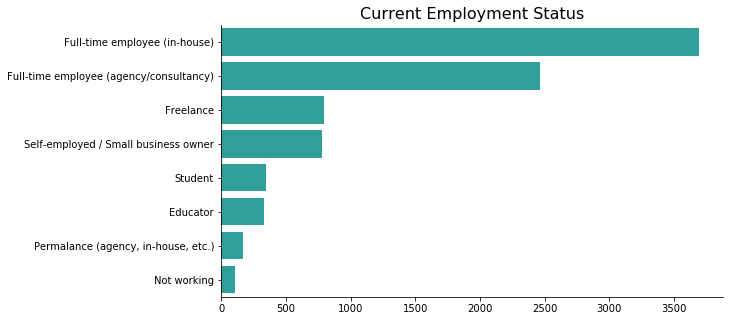

In [16]:
plot_categories(
    figsize=(9, 5),
    y="I am currently a/an:",
    order=census_data["I am currently a/an:"].value_counts().index,
    title="Current Employment Status",
)

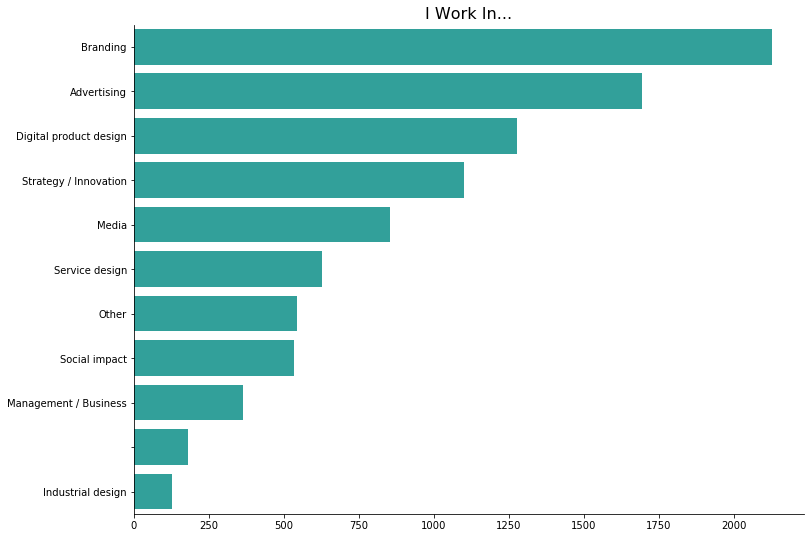

In [20]:
split_and_plot(col="I work in:.1", title="I Work In...")
plt.savefig("img/design_census/i_work_in1.png", bbox_inches="tight")

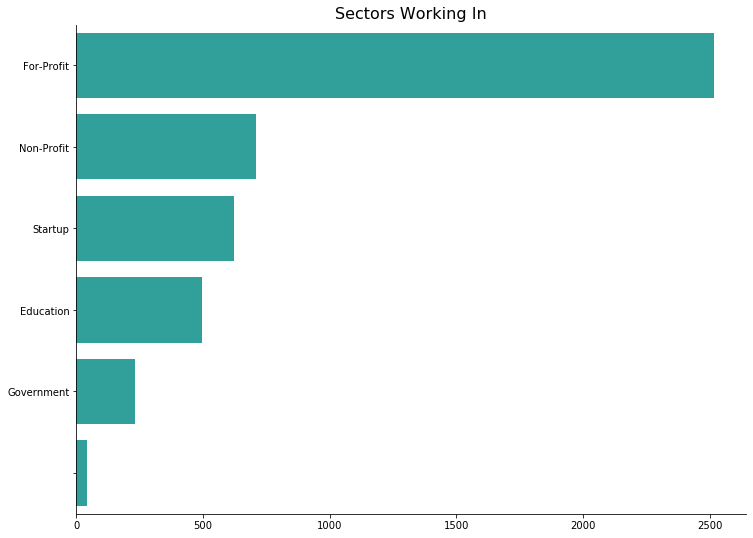

In [21]:
split_and_plot(col="I work in:.2", title="Sectors Working In")
plt.savefig("img/design_census/i_work_in2.png", bbox_inches="tight")

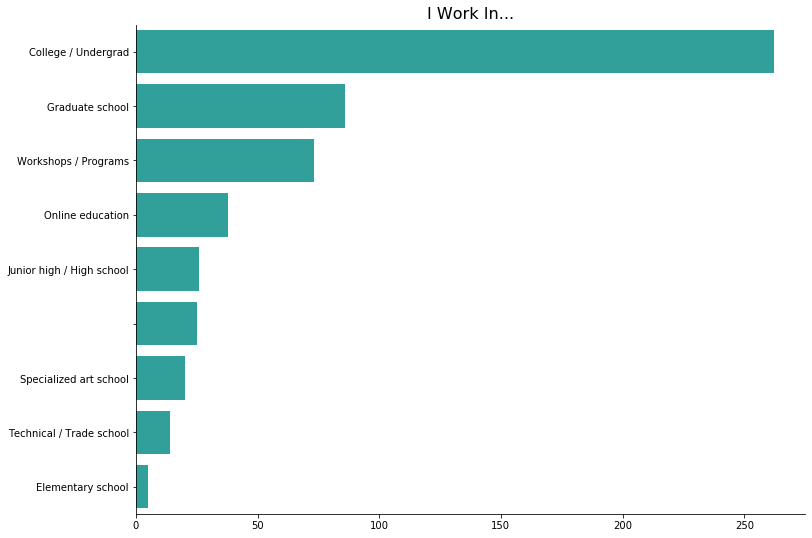

In [22]:
split_and_plot(col="I work in:.3", title="I Work In...")
plt.savefig("img/design_census/i_work_in3.png", bbox_inches="tight")

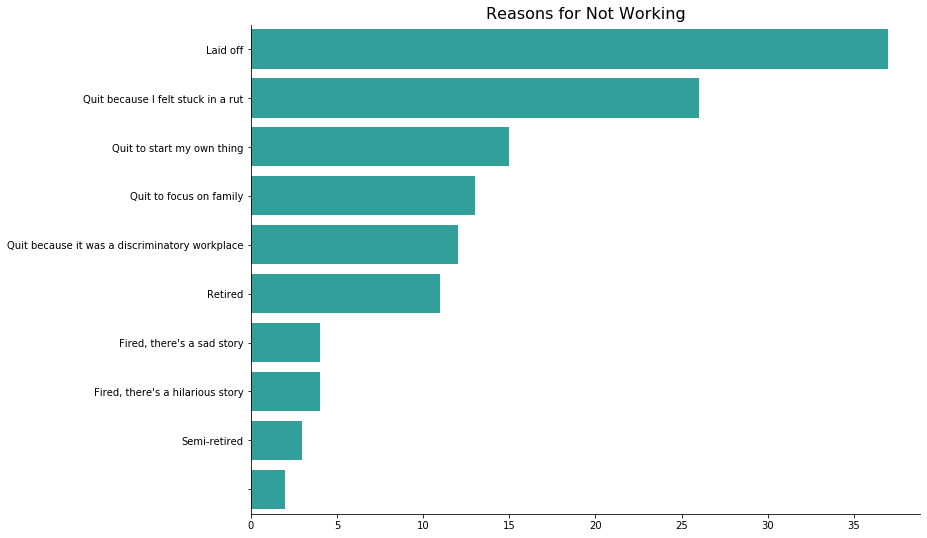

In [23]:
split_and_plot(col="I'm not currently working because:", title="Reasons for Not Working")

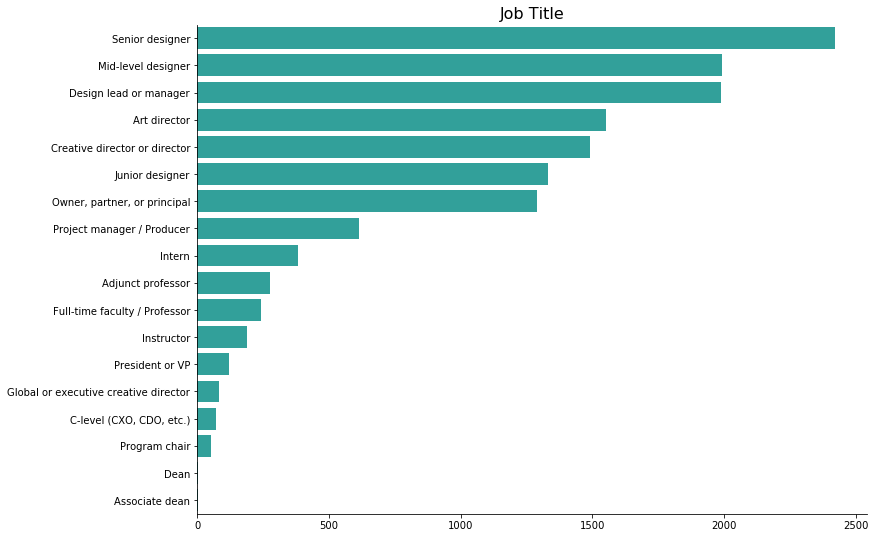

In [24]:
split_and_plot(col="I'm a/an:", title="Job Title")

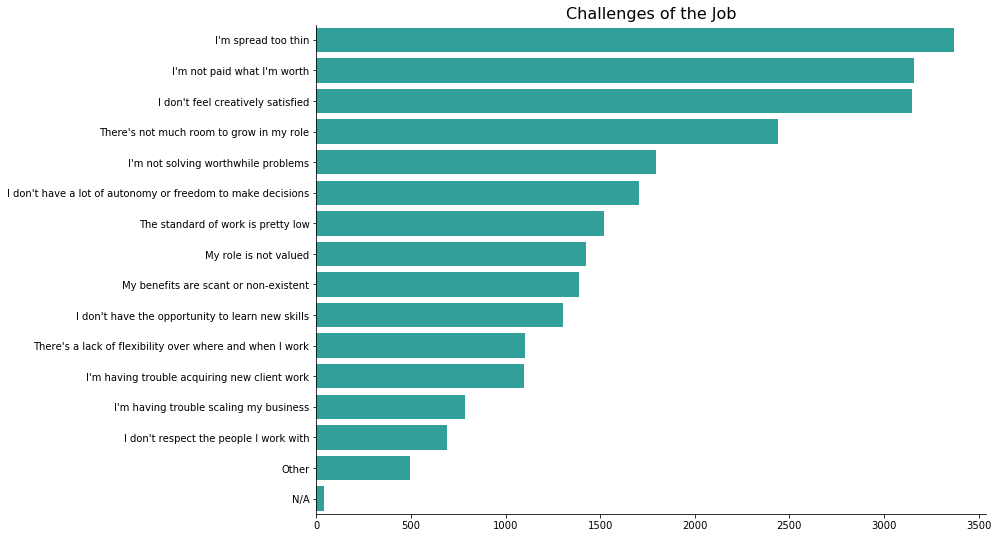

In [25]:
split_and_plot(col="My job is challenging because:", title="Challenges of the Job")

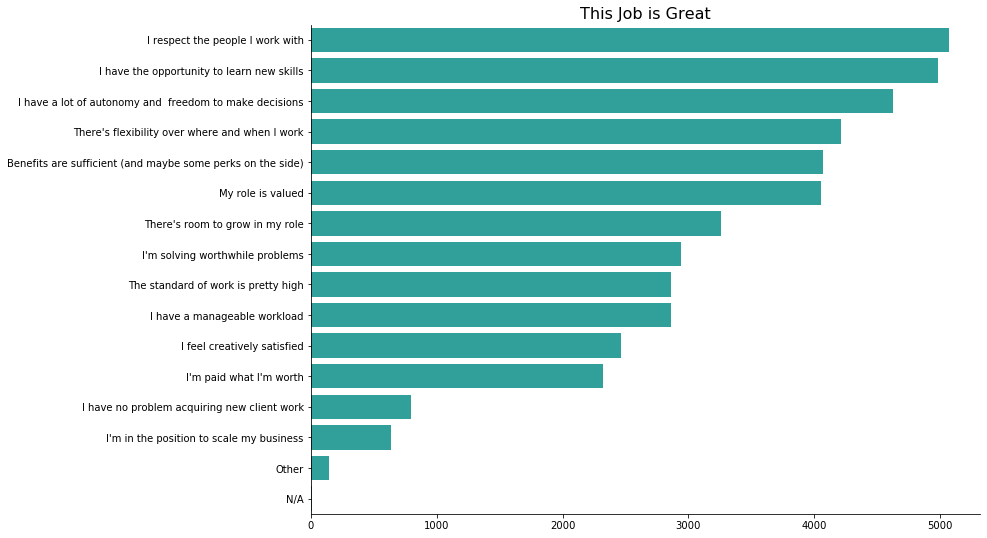

In [26]:
split_and_plot(col="My job is great because:", title="This Job is Great")

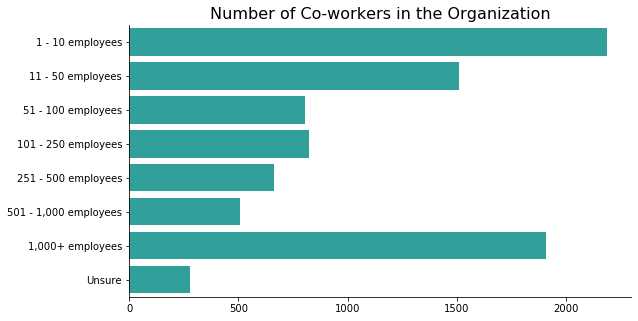

In [27]:
plot_categories(
    y="My organization has:",
    order=[
        "1 - 10 employees",
        "11 - 50 employees",
        "51 - 100 employees",
        "101 - 250 employees",
        "251 - 500 employees",
        "501 - 1,000 employees",
        "1,000+ employees",
        "Unsure"
    ],
    title="Number of Co-workers in the Organization"
)

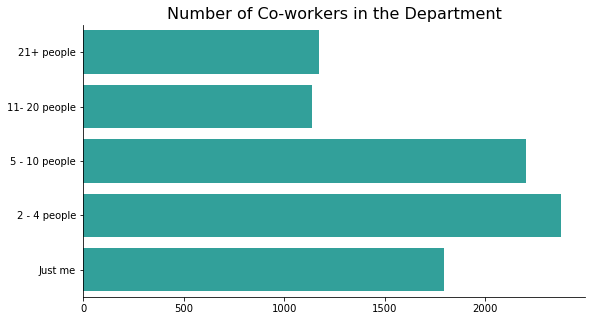

In [28]:
plot_categories(
    y="My department has:",
    order=[
        "21+ people",
        "11- 20 people",
        "5 - 10 people",
        "2 - 4 people",
        "Just me"
    ],
    title="Number of Co-workers in the Department"
)

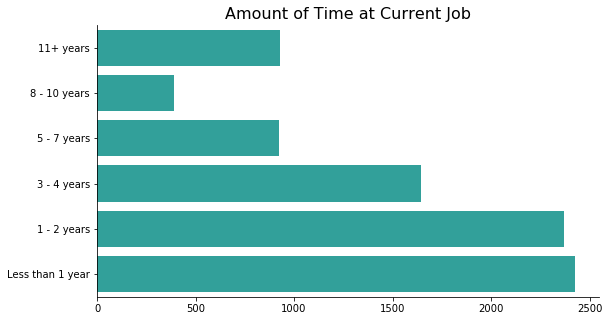

In [29]:
plot_categories(
    y="I've worked here for:",
    order=[
        "11+ years",
        "8 - 10 years",
        "5 - 7 years",
        "3 - 4 years",
        "1 - 2 years",
        "Less than 1 year"
    ],
    title="Amount of Time at Current Job"
)

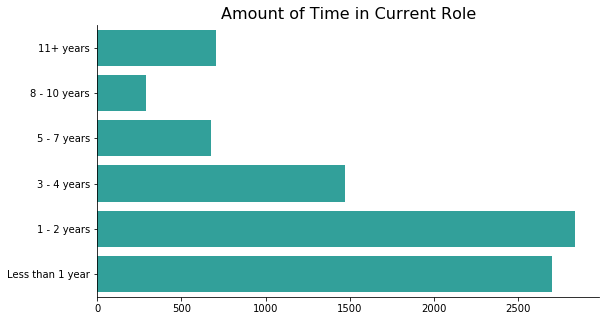

In [30]:
plot_categories(
    y="I've had my role for:",
    order=[
        "11+ years",
        "8 - 10 years",
        "5 - 7 years",
        "3 - 4 years",
        "1 - 2 years",
        "Less than 1 year"
    ],
    title="Amount of Time in Current Role"
)

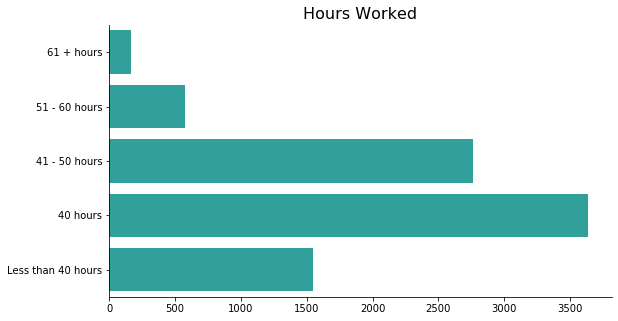

In [31]:
plot_categories(
    figsize=(9, 5),
    y='I typically work:',
    order=[
        "61 + hours",
        "51 - 60 hours",
        "41 - 50 hours",
        "40 hours","Less than 40 hours"
    ],
    title="Hours Worked",
)

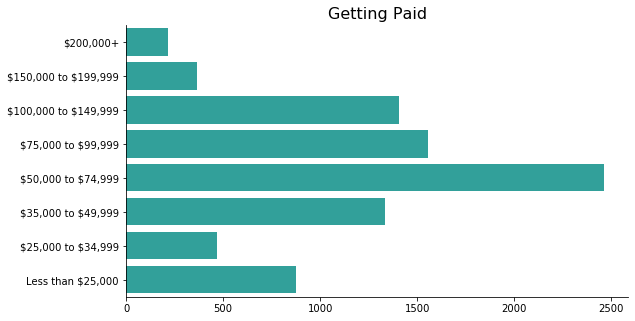

In [38]:
ax = plot_categories(
    y="I make:",
    order=[
        "$200,000+",
        "$150,000 to $199,999",
        "$100,000 to $149,999",
        "$75,000 to $99,999",
        "$50,000 to $74,999",
        "$35,000 to $49,999",
        "$25,000 to $34,999",
        "Less than $25,000"
    ],
    title="Getting Paid",
)
ax.set_yticklabels([
    "\$200,000+",
    "\$150,000 to \$199,999",
    "\$100,000 to \$149,999",
    "\$75,000 to \$99,999",
    "\$50,000 to \$74,999",
    "\$35,000 to \$49,999",
    "\$25,000 to \$34,999",
    "Less than \$25,000"
]
);

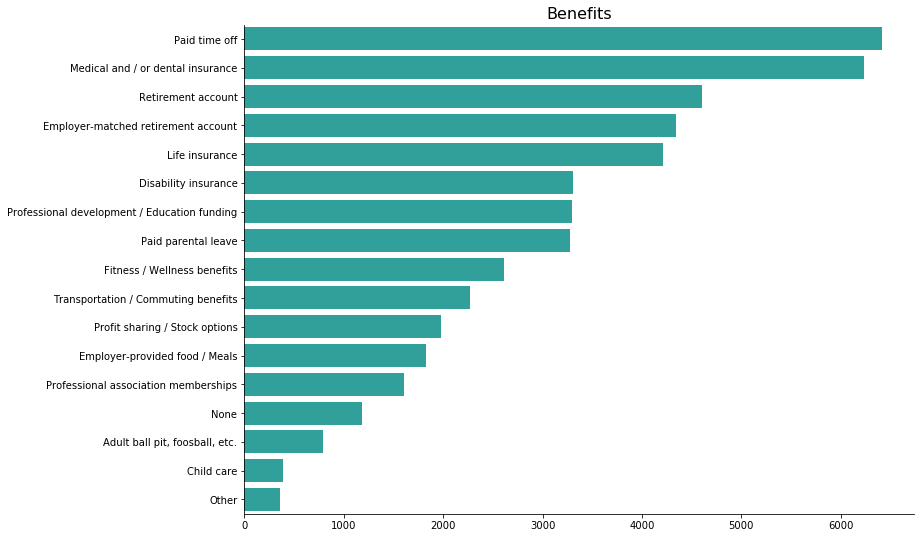

In [39]:
split_and_plot(col="My benefits include:", title="Benefits")

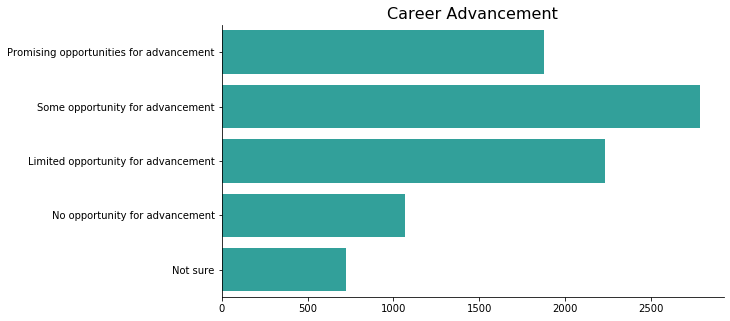

In [40]:
plot_categories(
    y="I have:",
    order=[
        'Promising opportunities for advancement',
        'Some opportunity for advancement',
        'Limited opportunity for advancement',
        'No opportunity for advancement',
        'Not sure', 
    ],
    title="Career Advancement"
)

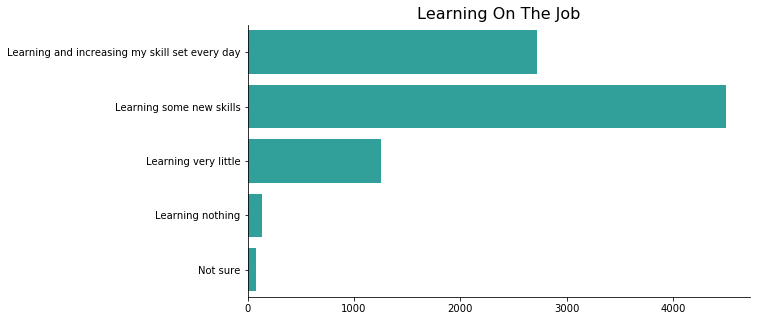

In [41]:
plot_categories(
    y="I am:",
    order=[
        'Learning and increasing my skill set every day',
        'Learning some new skills',
        'Learning very little',
        'Learning nothing',
        'Not sure'
    ],
    title="Learning On The Job"
)

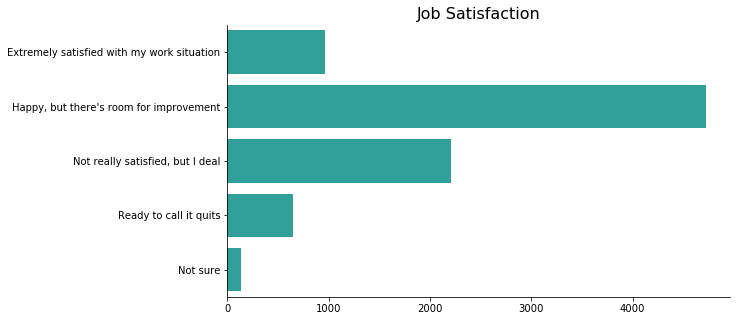

In [42]:
plot_categories(
    y="I am:.1",
    order=[
        'Extremely satisfied with my work situation',
        "Happy, but there's room for improvement",
        'Not really satisfied, but I deal',
        'Ready to call it quits', 
        'Not sure'
    ],
    title="Job Satisfaction"
);

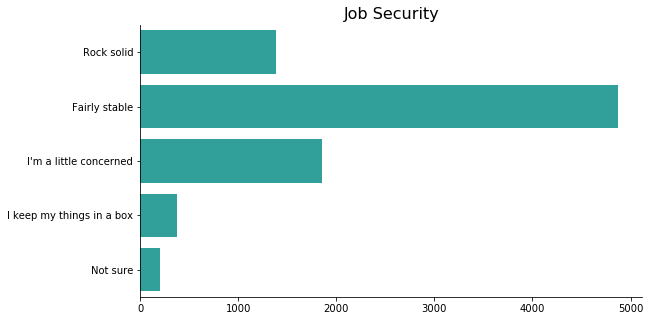

In [43]:
plot_categories(
    y="I feel:",
    order=[
        'Rock solid',
        'Fairly stable', 
        "I'm a little concerned",
        'I keep my things in a box',
        'Not sure',
    ],
    title="Job Security"
);

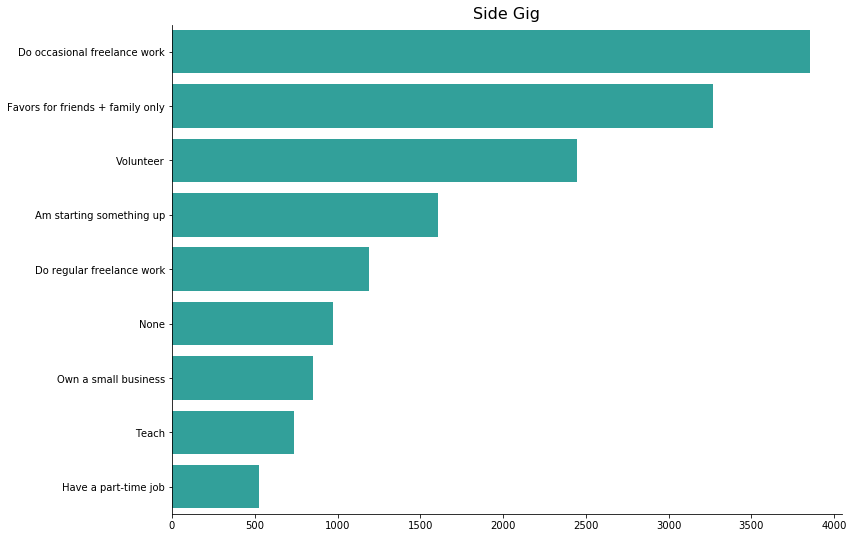

In [44]:
split_and_plot(col="On the side I:", title="Side Gig")

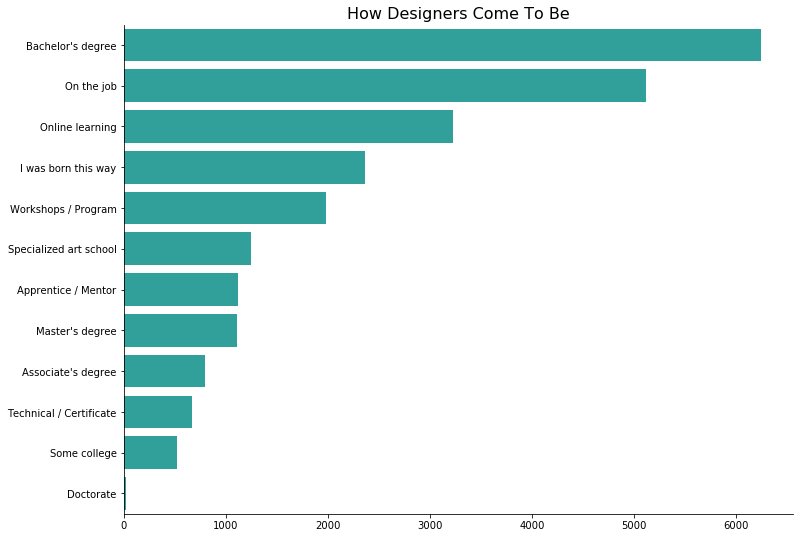

In [45]:
split_and_plot("I learned design from:", title="How Designers Come To Be")

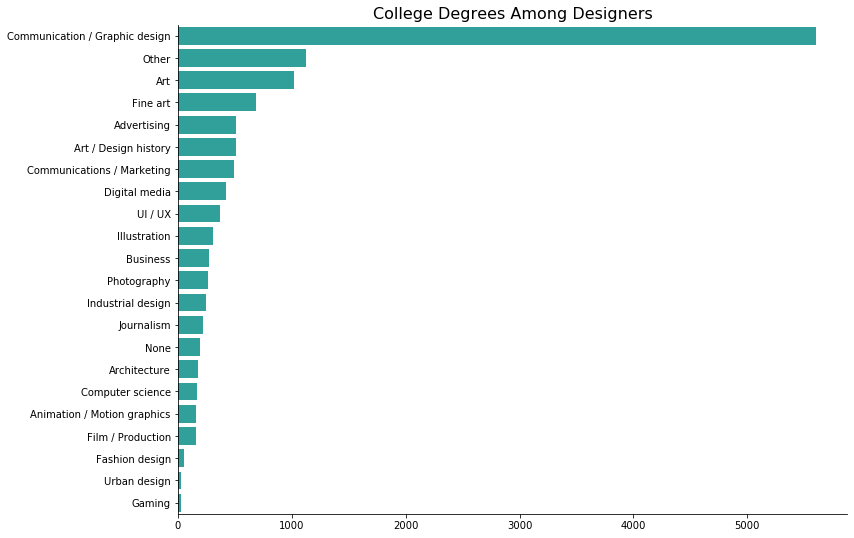

In [46]:
split_and_plot("I got my degree in:", title="College Degrees Among Designers")

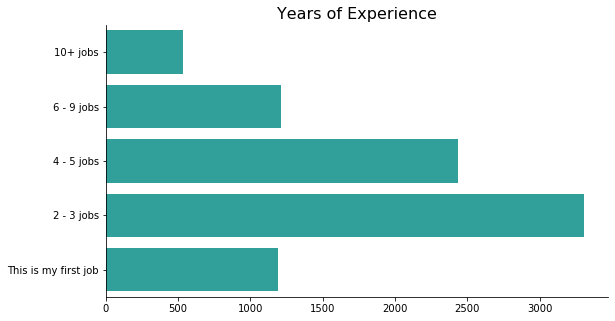

In [47]:
plot_categories(
    y="I've had:",
    order=[
        "10+ jobs",
        "6 - 9 jobs",
        "4 - 5 jobs",
        "2 - 3 jobs",
        "This is my first job"
    ],
    title="Years of Experience"
)

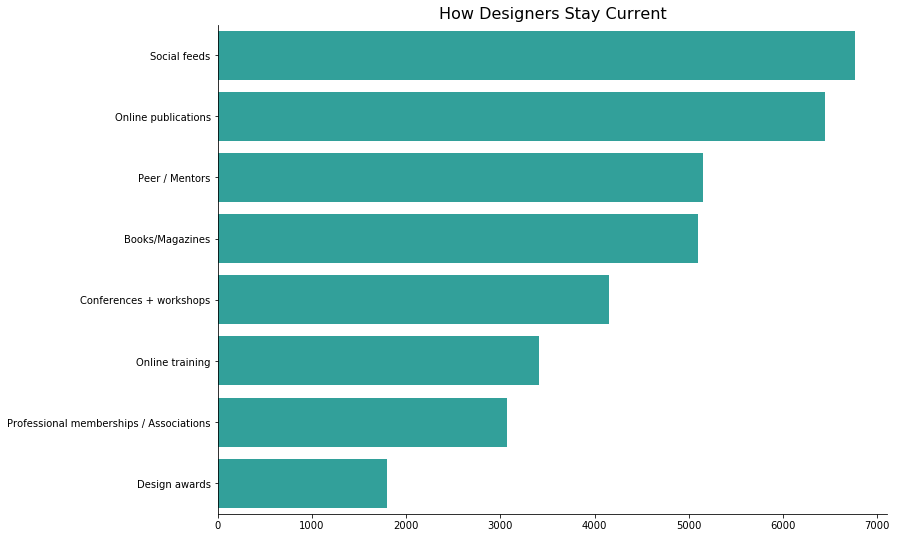

In [48]:
split_and_plot("I stay current with design by:", title="How Designers Stay Current")

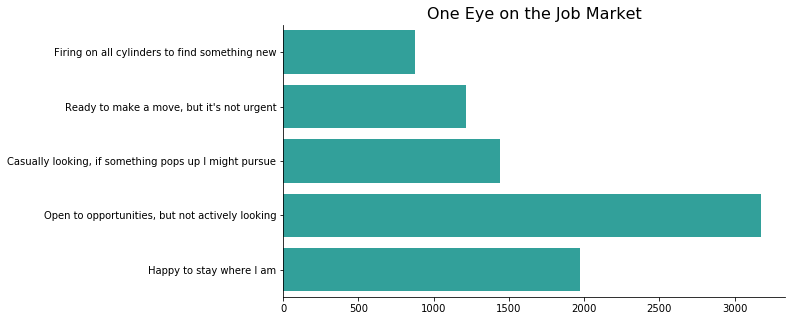

In [49]:
plot_categories(
    y="I'm currently:",
    order=[
        'Firing on all cylinders to find something new',
        "Ready to make a move, but it's not urgent",
        'Casually looking, if something pops up I might pursue',
        'Open to opportunities, but not actively looking',
        'Happy to stay where I am',
    ],
    title="One Eye on the Job Market"
);

In [81]:
map = folium.Map(location=[37.77, -122.42], zoom_start=10, tiles="Stamen Terrain")

marker_cluster = MarkerCluster().add_to(map) # create marker clusters

for i in range(census_data.shape[0]):
    location = [census_data['LAT'][i], census_data['LNG'][i]]
    tooltip = "Zipcode:{}<br />.".format(census_data["ZIP"][i])
    
    folium.Marker(location, 
                  tooltip=tooltip).add_to(marker_cluster)
map.save('img/design_census/locations.html')

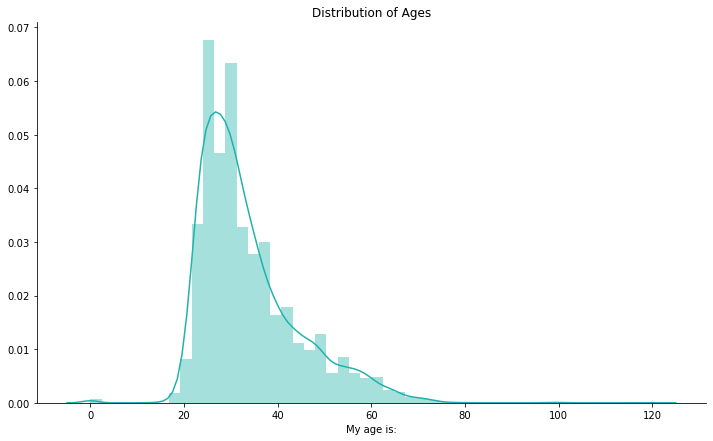

In [50]:
fig, ax = plt.subplots(figsize=(12,7))
sns.distplot(
    census_data[census_data["My age is:"] < 1000]["My age is:"], 
    ax=ax,
    color="lightseagreen"
)
ax.set_title("Distribution of Ages")
sns.despine()

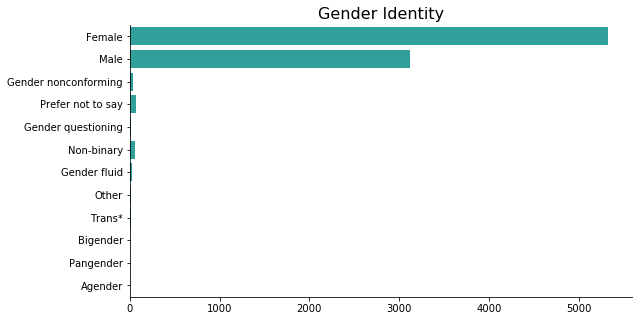

In [51]:
plot_categories(
    y="I identify as:",
    title="Gender Identity"
)

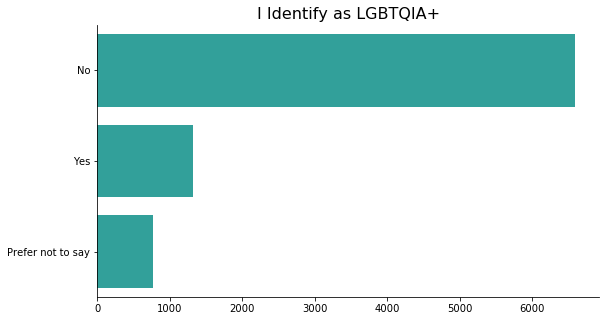

In [52]:
plot_categories(
    y="LGBTQIA+ status:",
    title="I Identify as LGBTQIA+"
)

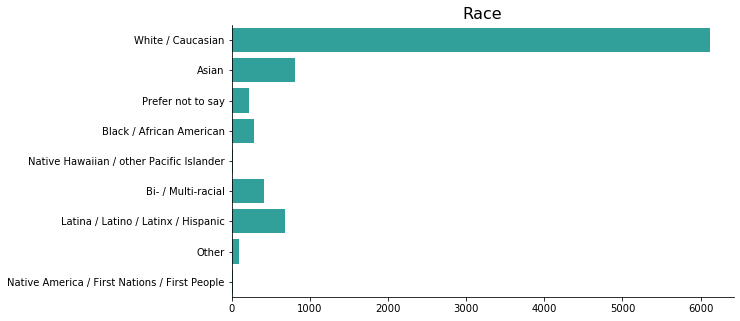

In [53]:
plot_categories(
    y="I am:.2",
    title="Race"
);

In [60]:
census_data.groupby("I am:.2")["I am:.2"].count().div(len(census_data))

I am:.2
Asian                                            0.093599
Bi- / Multi-racial                               0.048239
Black / African American                         0.033617
Latina / Latino / Latinx / Hispanic              0.078402
Native America / First Nations / First People    0.002418
Native Hawaiian / other Pacific Islander         0.002648
Other                                            0.011628
Prefer not to say                                0.025098
White / Caucasian                                0.704352
Name: I am:.2, dtype: float64

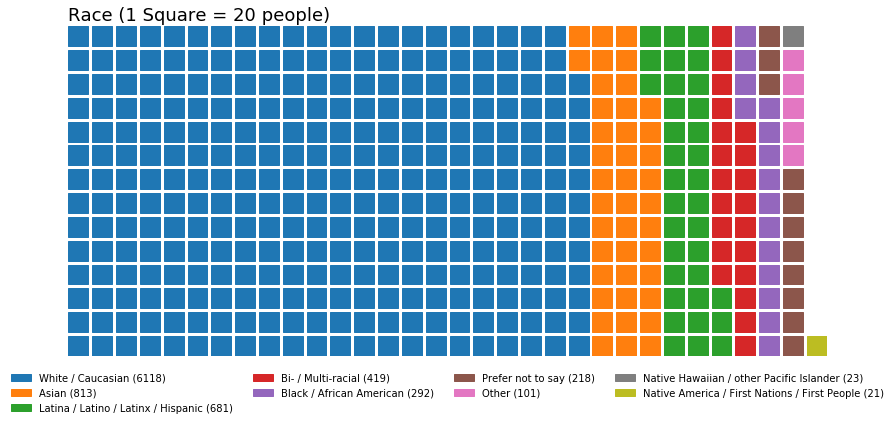

In [54]:
race_data = pd.DataFrame(census_data["I am:.2"].value_counts())

fig = plt.figure(
    FigureClass=Waffle,
    values = race_data['I am:.2'] / 20,
    labels = ["{0} ({1})".format(n, v) for n, v in race_data['I am:.2'].items()],
    legend = {'loc': 'lower center', 'ncol': 4, 'framealpha': 0, 'bbox_to_anchor': (0.5, -0.2)},
    title =  {'label': 'Race (1 Square = 20 people)', 'loc': 'left', "fontsize":18},
    rows = 14,
    colors = cm.get_cmap('tab10').colors[:9],
    figsize=(16,6)
)
plt.savefig("img/design_census/race_waffle.png", bbox_inches="tight")
plt.show()

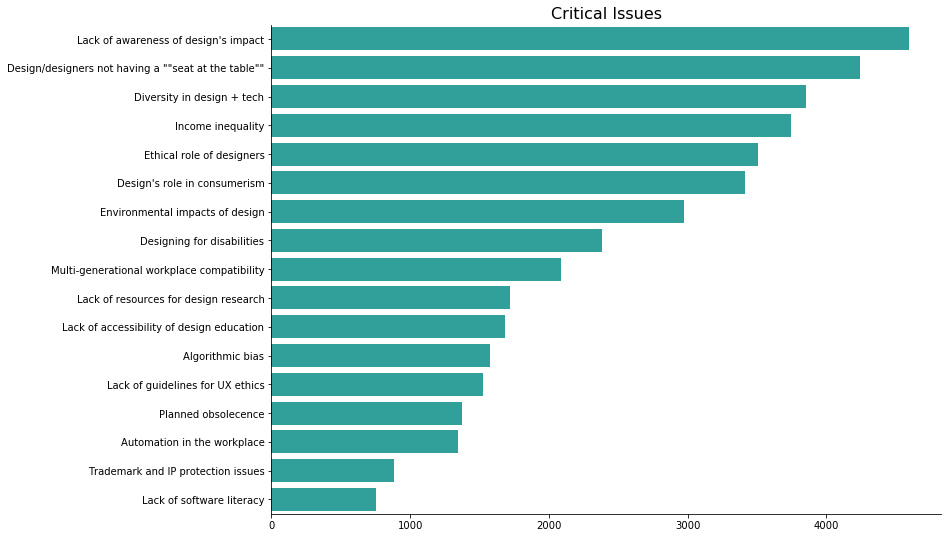

In [55]:
split_and_plot(
    col="I feel the most critical issues/challenges currently facing design are:",
    title="Critical Issues",
)

In [56]:
census_data['I feel the most critical issues/challenges currently facing design are:.1'].unique()[:3]

array(['Field over saturation, environmental impact, personal privacy',
       nan,
       'Diversity is a big problem, as much as it in other industries. Implicit biases play out at all levels, especially in tech, where gender and race are disproportionately male and white. I\'ve interviewed a fair amount, and I\'ve always felt at a disadvantage for ""culture fit"" or other vague euphemisms for the kind of people the interviewers are most comfortable with: themselves. I see the extroverted work style of overconfident yet underqualified white men  constantly rewarded with career advancement and resources, therefore reinforcing the power structure of men who hold the seats of power in design. Diversity also includes different types of work styles, viewpoints, and experiences. It\'s a weird hard challenge to overcome in the industry.'],
      dtype=object)

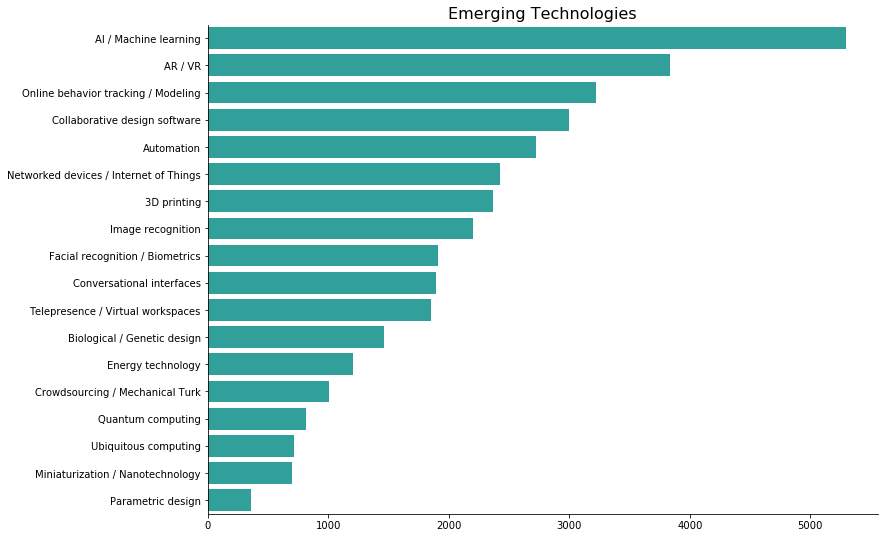

In [57]:
split_and_plot(
    col="I think the emerging/future technologies that will have the biggest impact on design are:",
    title="Emerging Technologies",
)

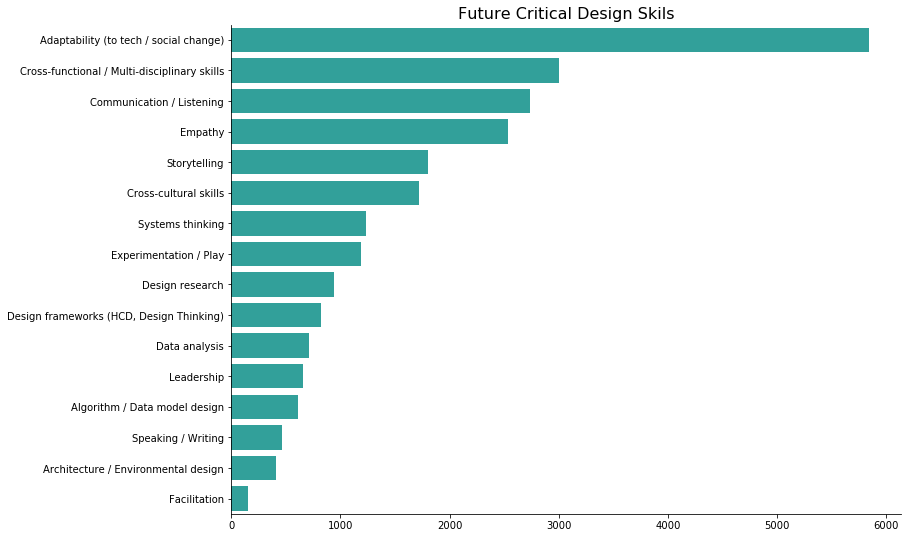

In [58]:
split_and_plot(
    col='I think the most critical design skills for the future will be:',
    title="Future Critical Design Skils"
)

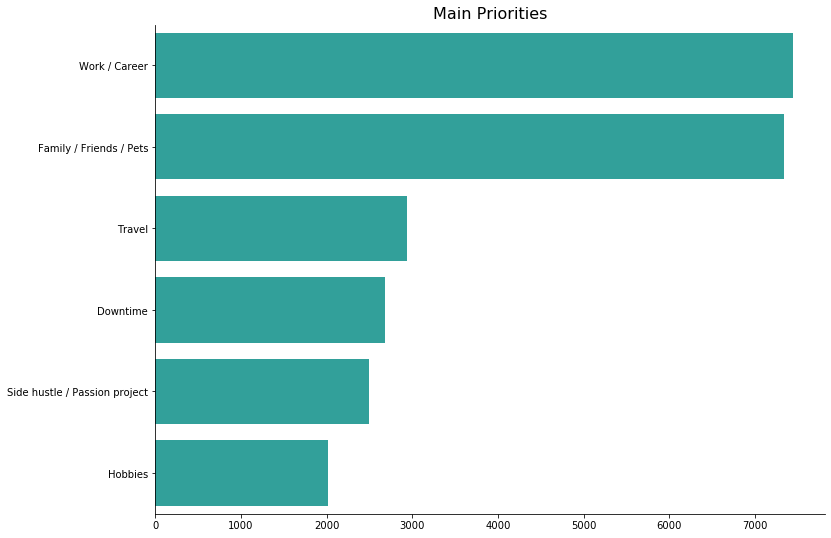

In [59]:
split_and_plot(
    col='My main priorities are:',
    title="Main Priorities"
)